In [1]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera
from tqdm import tqdm
from load import get_btch
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
tqdm.get_lock().locks = []

# decleare data parameters
par_train = {'data_dir'       : r'\Users\NeLy\Desktop\OMS_Dataset\OMS_Dataset', # Change data path here
             'out_dir'        : 'out', 
             'train_subjects' : ["7", "9a", "9b", "10", "11"],
             'test_subjects'  : ["9"]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

In [3]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

from liftpose.postprocess import load_test_results
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, _ = load_test_results(data, stat_2d, stat_3d)
Data, cameras = get_btch('9', par_train["data_dir"])

[main.py:410]:INFO:starting testing in path: out
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:60]:INFO:total params: 4.27M
[lift.py:66]:INFO:loading ckpt from 'out\ckpt_best.pth.tar'
[lift.py:74]:INFO:ckpt loaded (epoch: 2 | err: 0.4887202070567693)
[lift.py:110]:INFO:Saving results: C:\Users\NeLy\Desktop\LiftPose3D\examples\openmonkey\out\test_results.pth.tar


C:\Users\NeLy\Anaconda\envs\liftpose2\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\NeLy\Anaconda\envs\liftpose2\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


2732 ('9', 12460, '18261027')


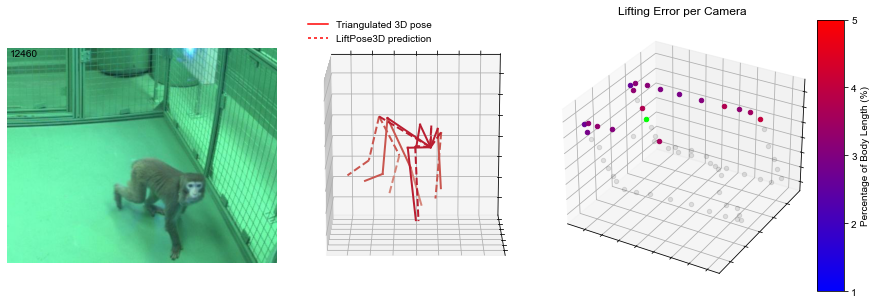

In [4]:
%matplotlib inline
from liftpose.plot import plot_pose_3d
from plot_util import *
from matplotlib.ticker import NullFormatter
import matplotlib.colors as mcol
import matplotlib as mpl
import matplotlib.cm as cm
mpl.pyplot.rcParams["font.family"] = ['Arial']
mpl.rcParams.update({'font.size': 10})

# define axis
fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=0, hspace=0)
gs1 = fig.add_gridspec(nrows=1, ncols=31)
ax2d = fig.add_subplot(gs1[:, :10])
ax3d = fig.add_subplot(gs1[:, 10:20], projection='3d')
ax3d_cameras = fig.add_subplot(gs1[:, 20:30], projection='3d')
ax_bar = fig.add_subplot(gs1[:, -1])

# load image and plot
idx = np.random.randint(test_3d_pred.shape[0])
k = list(Data.keys())[idx]
print(idx, k)

btch, img_id, cam = k
img_name = os.path.join(par['data_dir'], 'Images', 'batch' + str(btch) + '_' + str(img_id).zfill(9) + '_' + str(cam) + '.jpg')
ax2d.imshow(plt.imread(img_name))
ax2d.text(x=5, y=15, s=f"{img_id}")

ax3d.view_init(elev=-75, azim=-90)
plot_pose_3d(ax=ax3d, tar=test_3d_gt[idx],
             pred=test_3d_pred[idx],
             bones=par_data["vis"]["bones"], 
             limb_id=par_data["vis"]["limb_id"], 
             colors=par_data["vis"]["colors"], 
             normalize=True)

mi, ma = 1 / 100 * 2.2, 5 / 100 * 2.2
err = err_for_frame(Data, cameras, img_id, test_3d_gt, test_3d_pred)
plot_cameras_err(ax=ax3d_cameras, err=err, mi=mi, ma=ma, cameras=cameras, curr_camera=cam)

ax2d.axis('off')
lim = [-0.75, 0.75]
ax3d.set_xlim(lim)
ax3d.set_ylim(lim)
ax3d.set_zlim(lim)
# remove ticks
ax3d.xaxis.set_major_formatter(NullFormatter())
ax3d.yaxis.set_major_formatter(NullFormatter())
ax3d.zaxis.set_major_formatter(NullFormatter())
ax3d_cameras.xaxis.set_major_formatter(NullFormatter())
ax3d_cameras.yaxis.set_major_formatter(NullFormatter())
ax3d_cameras.zaxis.set_major_formatter(NullFormatter())

# setting titles
ax3d_cameras.set_title('Lifting Error per Camera')
cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
norm = mpl.colors.Normalize(vmin=mi/2.2 * 100, vmax=ma/2.2 * 100)
cb1 = mpl.colorbar.ColorbarBase(ax_bar, cmap=cmap,
                                norm=norm,
                                orientation='vertical', ticks=[1,2,3,4,5])
cb1.set_label('Percentage of Body Length (%)')

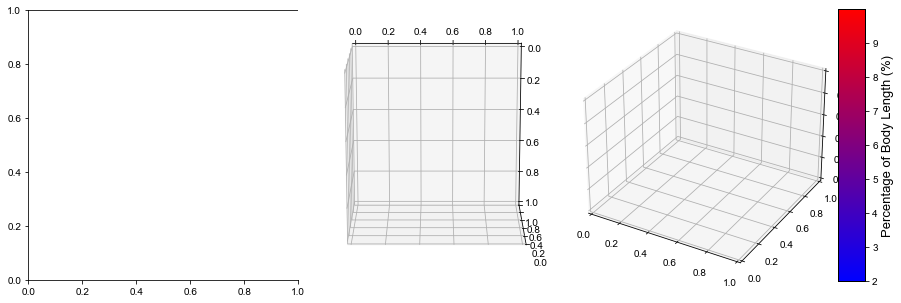

In [6]:
mpl.pyplot.rcParams["font.family"] = ['Arial']
mpl.rcParams.update({'font.size': 10})
np.random.seed(1234567)

out_path = par_train["out_dir"]
fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=0, hspace=0)
gs1 = fig.add_gridspec(nrows=1, ncols=31)
ax2d = fig.add_subplot(gs1[:, :10])
ax3d = fig.add_subplot(gs1[:, 10:20], projection='3d')
ax3d_cameras = fig.add_subplot(gs1[:, 20:30], projection='3d')
ax_bar = fig.add_subplot(gs1[:, -1])
for i in range(50):
    idx = np.random.randint(test_3d_pred.shape[0])
    k = list(Data.keys())[idx]

    btch, img_id, cam = k
    img_name = os.path.join(par['data_dir'], 'Images', 'batch' + str(btch) + '_' + str(img_id).zfill(9) + '_' + str(cam) + '.jpg')
    ax2d.imshow(plt.imread(img_name))
    ax2d.text(x=5, y=15, s=f"{img_id}")

    ax3d.view_init(elev=-75, azim=-90)
    plot_pose_3d(ax=ax3d, tar=test_3d_gt[idx],
                 pred=test_3d_pred[idx],
                 bones=par_data["vis"]["bones"], 
                 limb_id=par_data["vis"]["limb_id"], 
                 colors=par_data["vis"]["colors"], 
                 normalize=True)

    mi, ma = 2 / 100 * 2.2, 10 / 100 * 2.2
    err = err_for_frame(Data, cameras, img_id, test_3d_gt, test_3d_pred)
    plot_cameras_err(ax=ax3d_cameras, err=err, mi=mi, ma=ma, cameras=cameras, curr_camera=cam)

    ax2d.axis('off')
    lim = [-0.75, 0.75]
    ax3d.set_xlim(lim)
    ax3d.set_ylim(lim)
    ax3d.set_zlim(lim)
    # remove ticks
    ax3d.xaxis.set_major_formatter(NullFormatter())
    ax3d.yaxis.set_major_formatter(NullFormatter())
    ax3d.zaxis.set_major_formatter(NullFormatter())
    ax3d_cameras.xaxis.set_major_formatter(NullFormatter())
    ax3d_cameras.yaxis.set_major_formatter(NullFormatter())
    ax3d_cameras.zaxis.set_major_formatter(NullFormatter())

    # setting titles
    ax3d_cameras.set_title('Lifting Error per Camera')
    cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
    norm = mpl.colors.Normalize(vmin=mi/2.2 * 100, vmax=ma/2.2 * 100)
    cb1 = mpl.colorbar.ColorbarBase(ax_bar, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical',  ticks=np.arange(2, 10))
    cb1.set_label('Percentage of Body Length (%)',fontsize=13)
    
    plt.savefig(os.path.join(out_path, 'img{:03d}.jpg'.format(i)))
    ax3d_cameras.clear()
    ax3d.clear()
    ax2d.clear()

In [24]:
# -vb 20M 
!ffmpeg -framerate 1 -i out\\img%03d.jpg Video9.mp4 -y

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 9.2.1 (GCC) 20200122
  configuration: --disable-static --enable-shared --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libmfx --enable-amf --enable-ffnvcodec --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt
  libavutil 